# PROBLEM EXPLANATION

Stock market is one of the biggest indicators of a country’s economic strength and also one of the best 
investment methods for many person, company and organization. The ability to predict the values in 
stock marketing is everyone’s dream and there are lots of works on that in recent history.
Traditional approaches are often used to estimate stock values.
In this study, price is tried to be predicted with KNN and RandomForest models, both with and without Google Trends "interest over time" dataset

# LIBRARIES

In [48]:
from pytrends.request import TrendReq
pytrend = TrendReq()

import matplotlib
import yfinance as yf
import plotly.graph_objs as go
import pandas as pd 
import pandas as pd
import numpy as np  
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt
from sklearn import model_selection

from sklearn.preprocessing import scale, MinMaxScaler

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from warnings import filterwarnings

filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (30,10)

# DATA PREPERATION

## First dataset (Past values of BTCUSD)

In [49]:
past_vals_df = yf.download(tickers='BTC-USD', start="2020-05-01", end="2021-01-01")

[*********************100%***********************]  1 of 1 completed


### First glance

In [50]:
past_vals_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-30,8797.669922,9440.650391,8533.255859,8658.553711,8658.553711,66964629541
2020-05-01,8672.782227,9048.023438,8667.763672,8864.766602,8864.766602,44068389997
2020-05-02,8869.057617,9007.187500,8811.366211,8988.596680,8988.596680,40134388683
2020-05-03,8983.614258,9167.781250,8830.971680,8897.468750,8897.468750,47101785174
2020-05-04,8895.745117,8956.906250,8645.024414,8912.654297,8912.654297,45718796276


In [51]:
past_vals_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,243.0,1.256819e+04,4.337866e+03,8.610386e+03,9.502154e+03,1.093493e+04,1.360233e+04,2.884157e+04
High,243.0,1.284868e+04,4.546315e+03,8.949898e+03,9.639205e+03,1.110012e+04,1.384986e+04,2.924488e+04
Low,243.0,1.234102e+04,4.225381e+03,8.374323e+03,9.337995e+03,1.071668e+04,1.328430e+04,2.820199e+04
Close,243.0,1.265103e+04,4.457602e+03,8.601796e+03,9.524172e+03,1.094459e+04,1.369566e+04,2.900172e+04
Adj Close,243.0,1.265103e+04,4.457602e+03,8.601796e+03,9.524172e+03,1.094459e+04,1.369566e+04,2.900172e+04
Volume,243.0,2.965302e+10,1.178204e+10,1.225260e+10,2.054569e+10,2.669970e+10,3.664816e+10,7.137861e+10


In [52]:
past_vals_df.isnull().values.any()

False

### Visualization

<AxesSubplot:title={'center':'BTC values in between 2020-05-01 and 2021-01-01'}, xlabel='Date'>

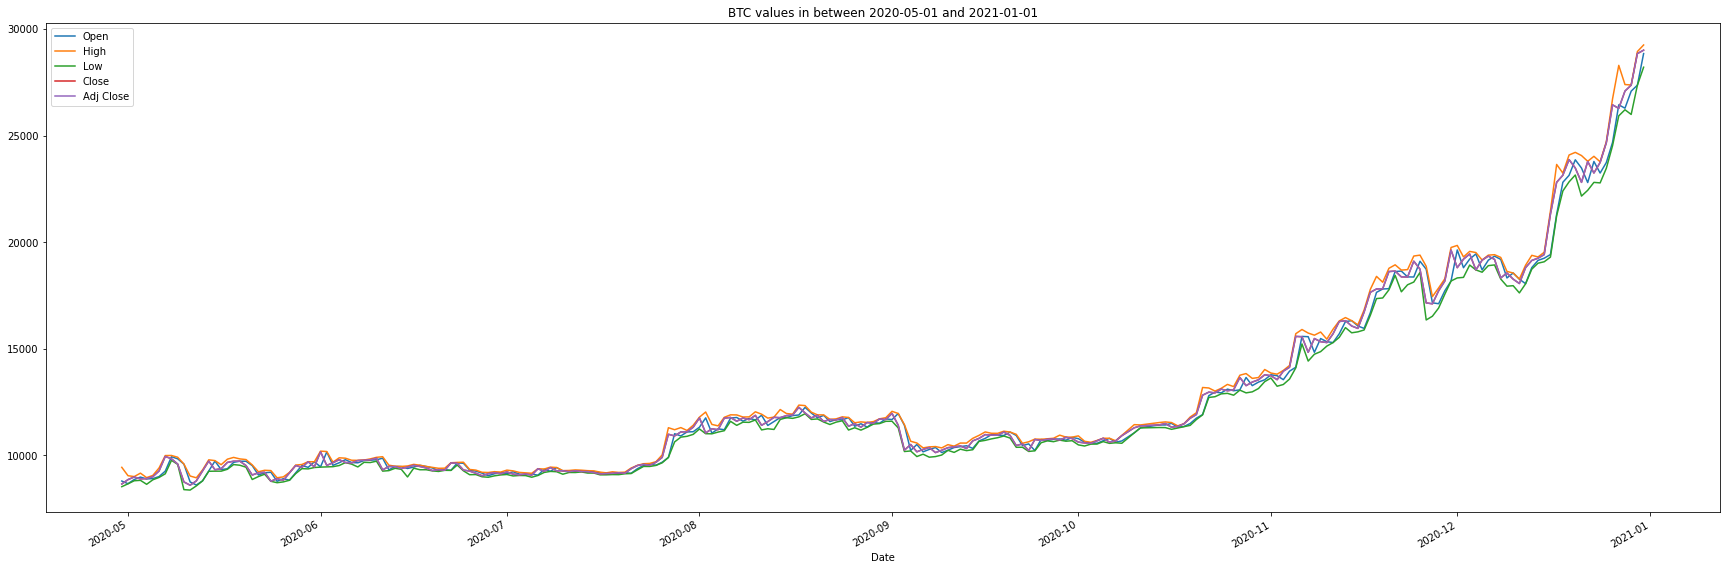

In [53]:
# To visualize the dataset better, drop "Volume"
visual_past_vals_df = past_vals_df.drop(["Volume"], axis = 1)
visual_past_vals_df.plot(title = "BTC values in between 2020-05-01 and 2021-01-01")

## Second dataset (BTC keyword interest all World search included)

In [54]:
pytrend.build_payload(kw_list=["BTC"], timeframe = "2020-05-01 2021-01-01")
interest_df = pytrend.interest_over_time()

### First glance

In [55]:
interest_df.head()

,BTC,isPartial
date,,
2020-05-01,34,False
2020-05-02,30,False
2020-05-03,34,False
2020-05-04,29,False
2020-05-05,29,False


In [56]:
interest_df.describe().T

,count,mean,std,min,25%,50%,75%,max
BTC,246.0,31.788618,12.714608,17.0,23.0,28.0,35.0,100.0


In [57]:
interest_df.isnull().values.any()

False

### Visualization

<AxesSubplot:title={'center':'Google Trends - Interest Over time - in between 2020-05-01 and 2021-01-01'}, xlabel='date'>

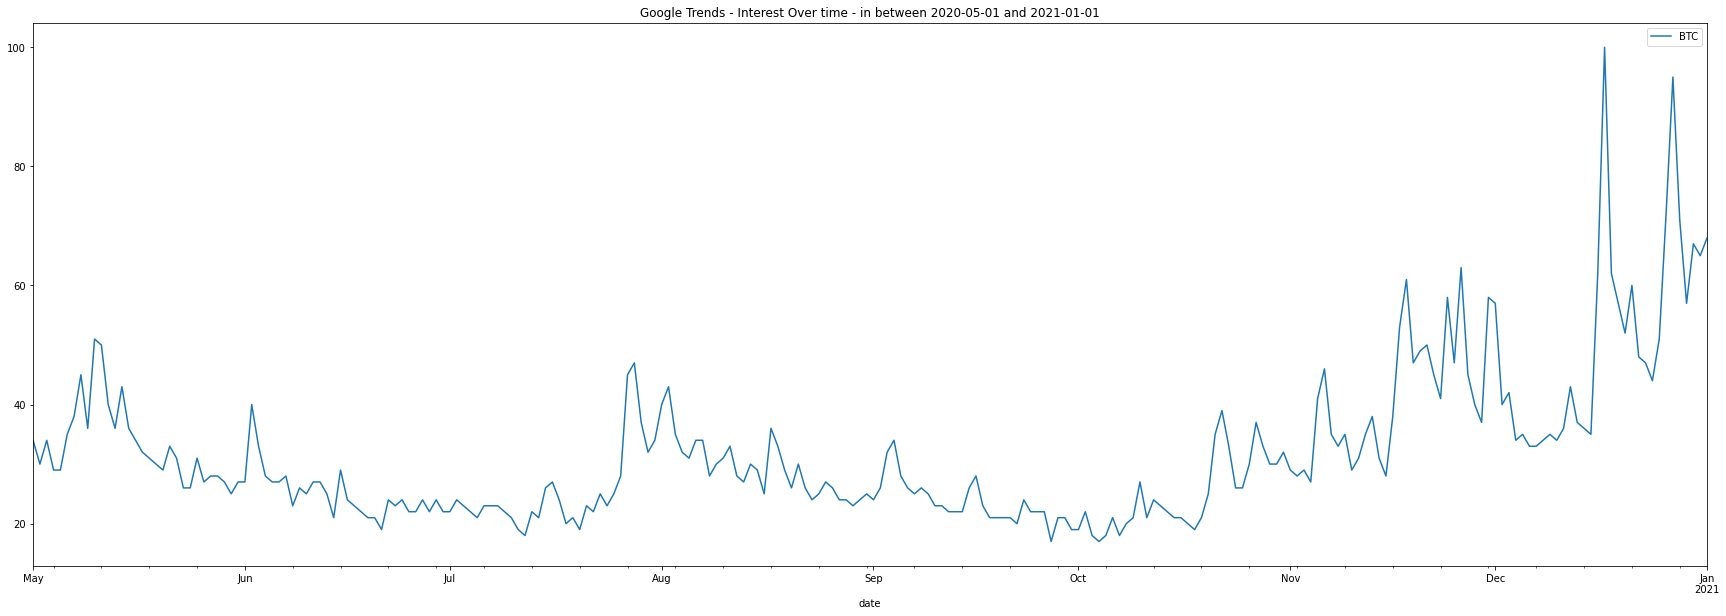

In [58]:
interest_df.plot(title = "Google Trends - Interest Over time - in between 2020-05-01 and 2021-01-01")

## Final data

In [59]:
merged_df = pd.merge(past_vals_df, interest_df, how='inner', left_index=True, right_index=True)
merged_df.drop(["isPartial"], axis = 1, inplace = True)

<AxesSubplot:>

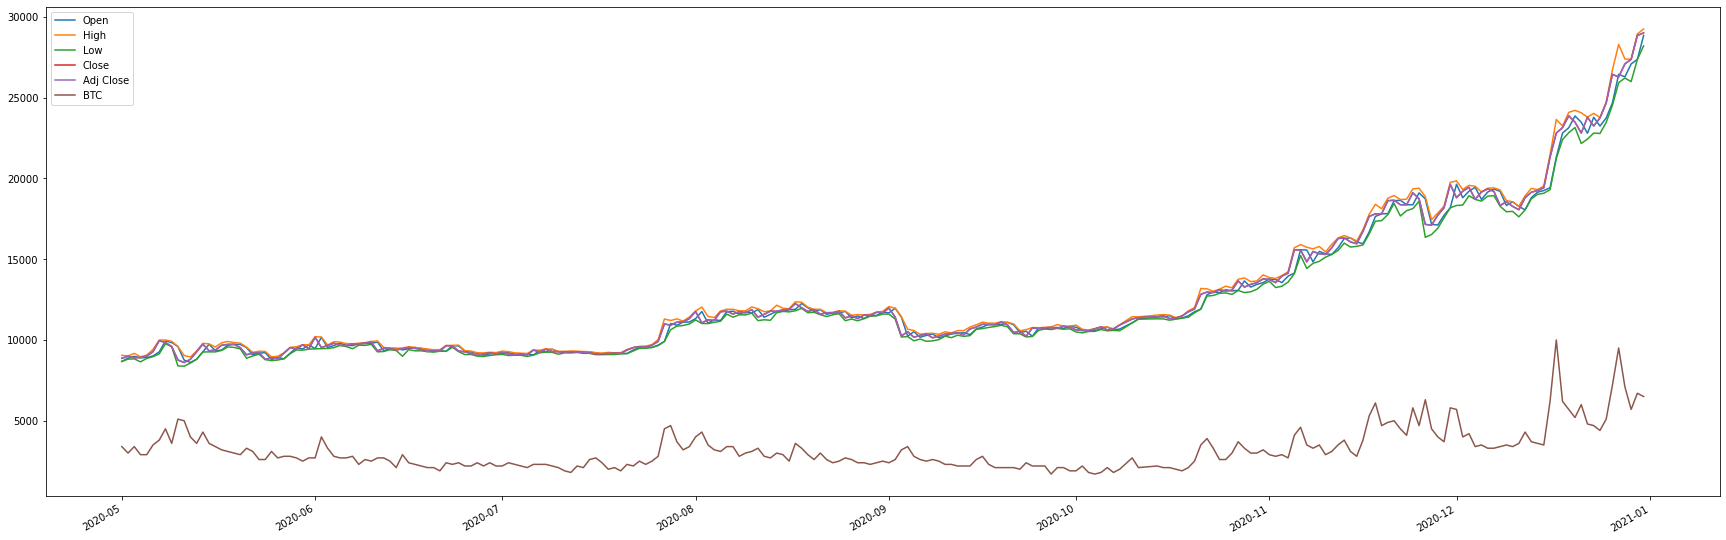

In [60]:
visual_merged_df = pd.merge(past_vals_df, interest_df * 100, how='inner', left_index=True, right_index=True)
visual_merged_df.drop(["Volume", "isPartial"], axis = 1, inplace = True)
visual_merged_df.plot()

<AxesSubplot:>

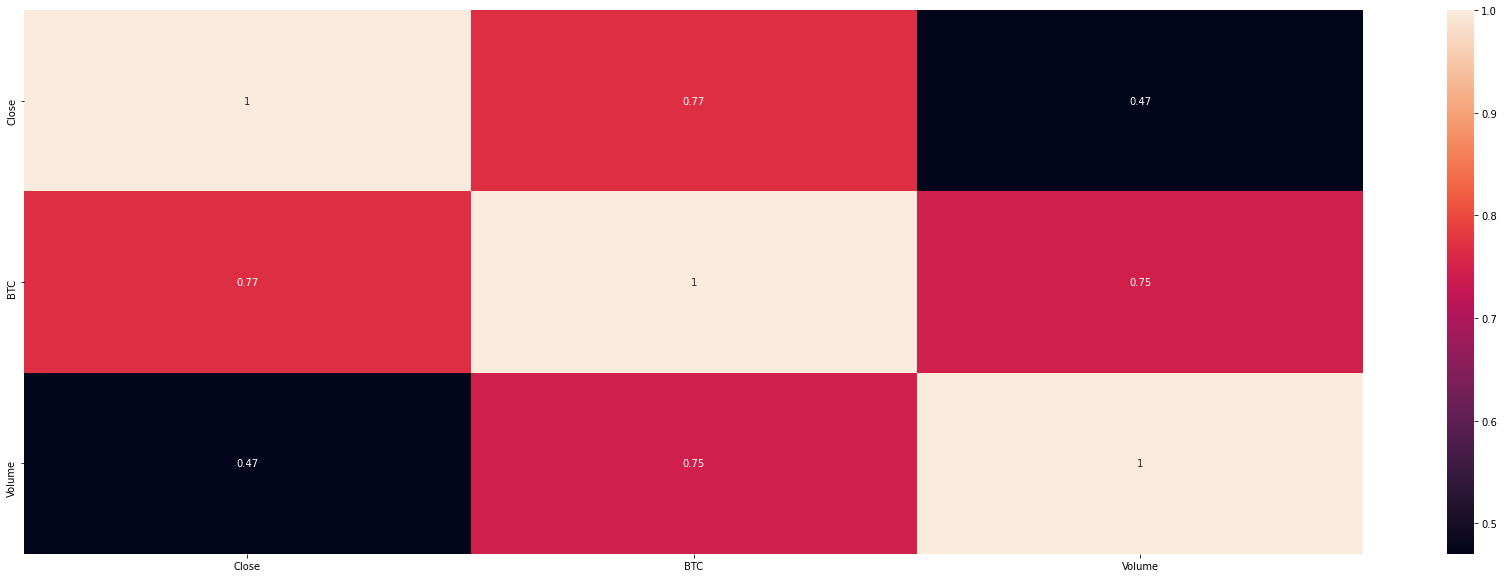

In [61]:
check_corr_df = pd.DataFrame()
check_corr_df["Close"] = merged_df["Close"]
check_corr_df["BTC"] = merged_df["BTC"]
check_corr_df["Volume"] = merged_df["Volume"]

corr = check_corr_df.corr()
sns.heatmap(corr, annot = True)

In [62]:
final_df =  pd.DataFrame()
final_df = merged_df.copy()
final_df["Close_shifted"] = merged_df["Close"].shift(-1)
final_df.drop(final_df.index[-1], inplace=True)
final_df.head()

,Open,High,Low,Close,Adj Close,Volume,BTC,Close_shifted
2020-05-01,8672.782227,9048.023438,8667.763672,8864.766602,8864.766602,44068389997,34,8988.596680
2020-05-02,8869.057617,9007.187500,8811.366211,8988.596680,8988.596680,40134388683,30,8897.468750
2020-05-03,8983.614258,9167.781250,8830.971680,8897.468750,8897.468750,47101785174,34,8912.654297
2020-05-04,8895.745117,8956.906250,8645.024414,8912.654297,8912.654297,45718796276,29,9003.070312
2020-05-05,8912.832031,9062.415039,8856.827148,9003.070312,9003.070312,43148462663,29,9268.761719


## Scaled Final data

In [63]:
scaler = MinMaxScaler()

final_scaled = scaler.fit_transform(final_df)
col_names = ["Open", "High", "Low", "Close", "Adj Close", "Volume", "BTC", "Close_shifted"]
final_df_scaled = pd.DataFrame(final_scaled, columns = col_names)
final_df_scaled.head()

# unscaled = scaler.inverse_transform(scaled_final)
# unscaled_df = pd.DataFrame(unscaled)

,Open,High,Low,Close,Adj Close,Volume,BTC,Close_shifted
0,0.003328,0.004909,0.015456,0.012993,0.012993,0.538101,0.204819,0.018961
1,0.013796,0.002866,0.023020,0.019112,0.019112,0.471566,0.156627,0.014494
2,0.019906,0.010901,0.024052,0.014609,0.014609,0.589405,0.204819,0.015238
3,0.015219,0.000351,0.014258,0.015359,0.015359,0.566015,0.144578,0.019670
4,0.016131,0.005629,0.025414,0.019827,0.019827,0.522543,0.144578,0.032695


# MODEL TRAINING

## Arranging X and Y datasets

In [64]:
y = final_df["Close_shifted"]
X_ = final_df.drop(["Close_shifted"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.25, random_state = 123)

In [65]:
y_scaled = final_df_scaled["Close_shifted"]
X_scaled = final_df_scaled.drop(["Close_shifted"], axis = 1)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size = 0.25, random_state = 123)

## KNN - unscaled

In [66]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [67]:
knn_model.n_neighbors

5

### Prediction & Performance metrics

In [68]:
y_pred_knn = knn_model.predict(X_test)
y_pred_knn[0:5]

array([14918.52773438, 12546.90605469, 10677.378125  ,  9569.11855469,
       13268.83769531])

In [69]:
scala = merged_df["Close"].max() - merged_df["Close"].min()
print("In the interval", scala, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_knn)))
print("MSE: ", mean_squared_error(y_test, y_pred_knn))
print("MAE: ", mean_absolute_error(y_test, y_pred_knn))

In the interval 20399.9248046875 , performance metrics are as follows
RMSE:  4023.92349826773
MSE:  16191960.319911204
MAE:  2991.3420338114756


### RESULT VISUALIZATION

<AxesSubplot:title={'center':'Real Close values as y_test ; Close predictions with knn as y_pred_knn'}>

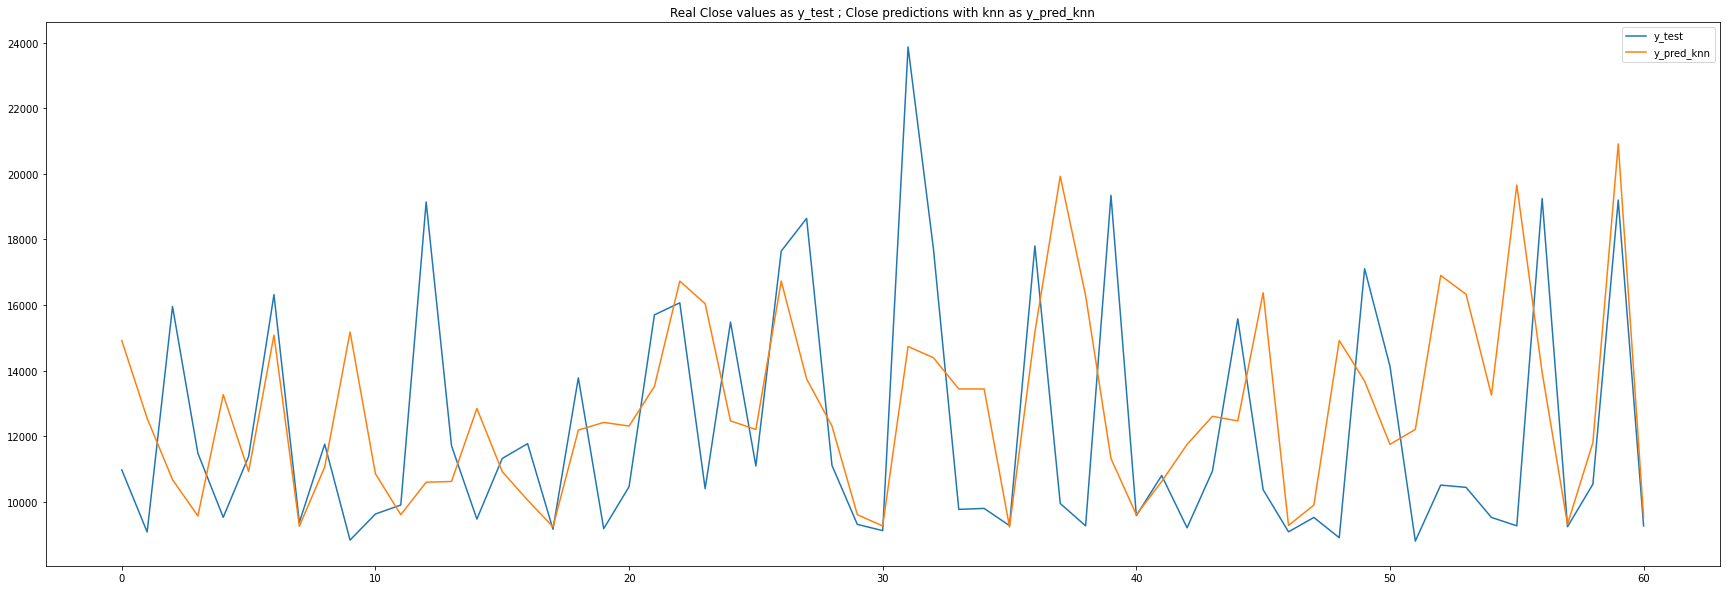

In [70]:
list_of_tuples = list(zip(y_test, y_pred_knn))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test', 'y_pred_knn'])
knn_res_df.plot(title ="Real Close values as y_test ; Close predictions with knn as y_pred_knn")

## KNN - scaled

In [71]:
knn_model_scaled = KNeighborsRegressor()
knn_model_scaled.fit(X_train_scaled, y_train_scaled)

KNeighborsRegressor()

In [72]:
knn_model_scaled.n_neighbors

5

### Prediction & Performance Metrics

In [73]:
y_pred_knn_scaled = knn_model_scaled.predict(X_test_scaled)
y_pred_knn_scaled[0:5]

array([0.09599706, 0.04951836, 0.38023844, 0.13860706, 0.05848533])

In [74]:
scala = final_df_scaled["Close"].max() - final_df_scaled["Close"].min()
print("In the interval", scala, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test_scaled, y_pred_knn_scaled)))
print("MSE: ", mean_squared_error(y_test_scaled, y_pred_knn_scaled))
print("MAE: ", mean_absolute_error(y_test_scaled, y_pred_knn_scaled))

In the interval 1.0 , performance metrics are as follows
RMSE:  0.02219594916349967
MSE:  0.0004926601592686618
MAE:  0.01491509733623209


### Result Visualization

<AxesSubplot:title={'center':'Scaled Real Close values as y_test_scaled ; Close predictions with knn as y_pred_knn_scaled'}>

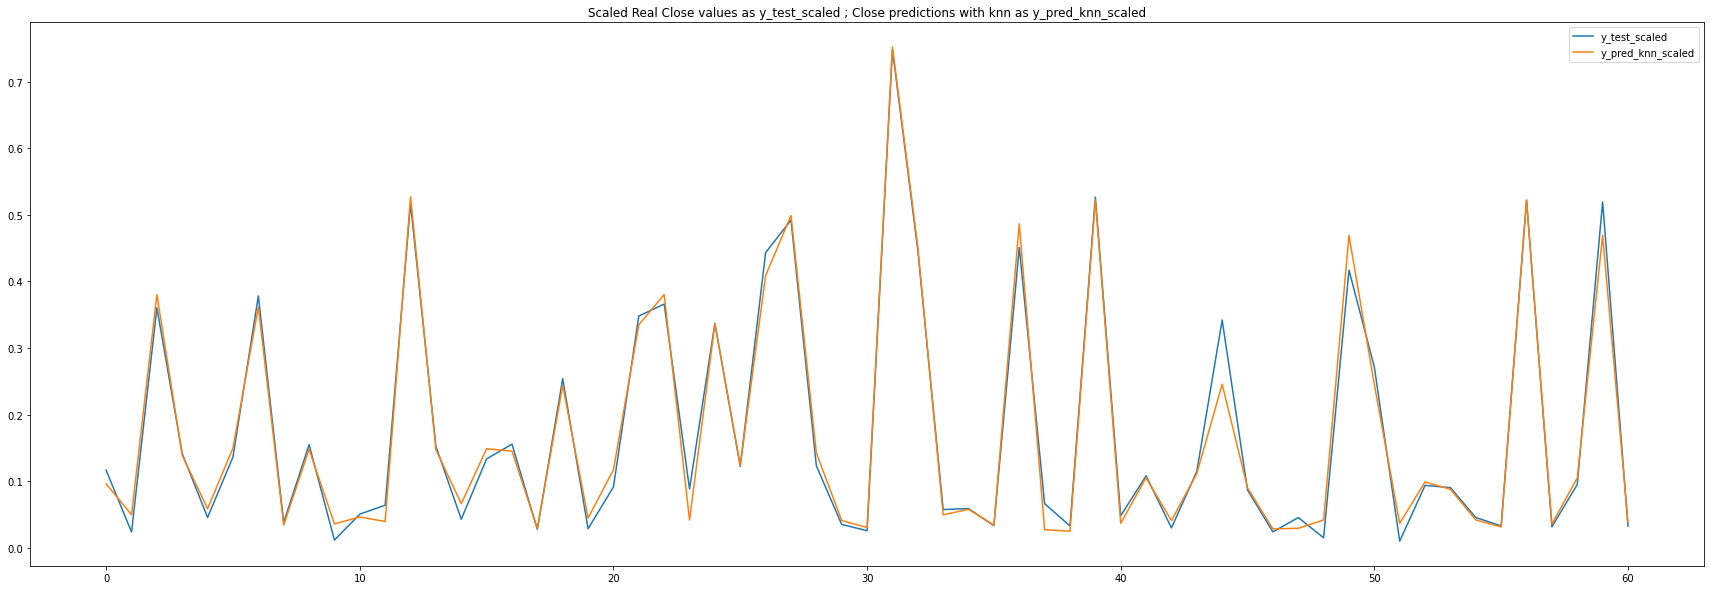

In [75]:
list_of_tuples = list(zip(y_test_scaled, y_pred_knn_scaled))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test_scaled', 'y_pred_knn_scaled'])
knn_res_df.plot(title ="Scaled Real Close values as y_test_scaled ; Close predictions with knn as y_pred_knn_scaled")

## RF - unscaled

In [76]:
rf_model =  RandomForestRegressor(random_state = 123)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=123)

### Prediction & Performance metrics

In [77]:
y_pred_rf = rf_model.predict(X_test)
y_pred_rf[0:5]

array([10738.64173828,  9657.83166992, 16395.5075    , 11473.18178711,
       10201.87180664])

In [78]:
scala = merged_df["Close"].max() - merged_df["Close"].min()
print("In the interval", scala, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MSE: ", mean_squared_error(y_test, y_pred_rf))
print("MAE: ", mean_absolute_error(y_test, y_pred_rf))

In the interval 20399.9248046875 , performance metrics are as follows
RMSE:  412.87813424445994
MSE:  170468.3537371863
MAE:  283.1282353035347


### Result visualization

<AxesSubplot:title={'center':'Real Close values as y_test ; Close predictions with randomForest as y_pred_rf'}>

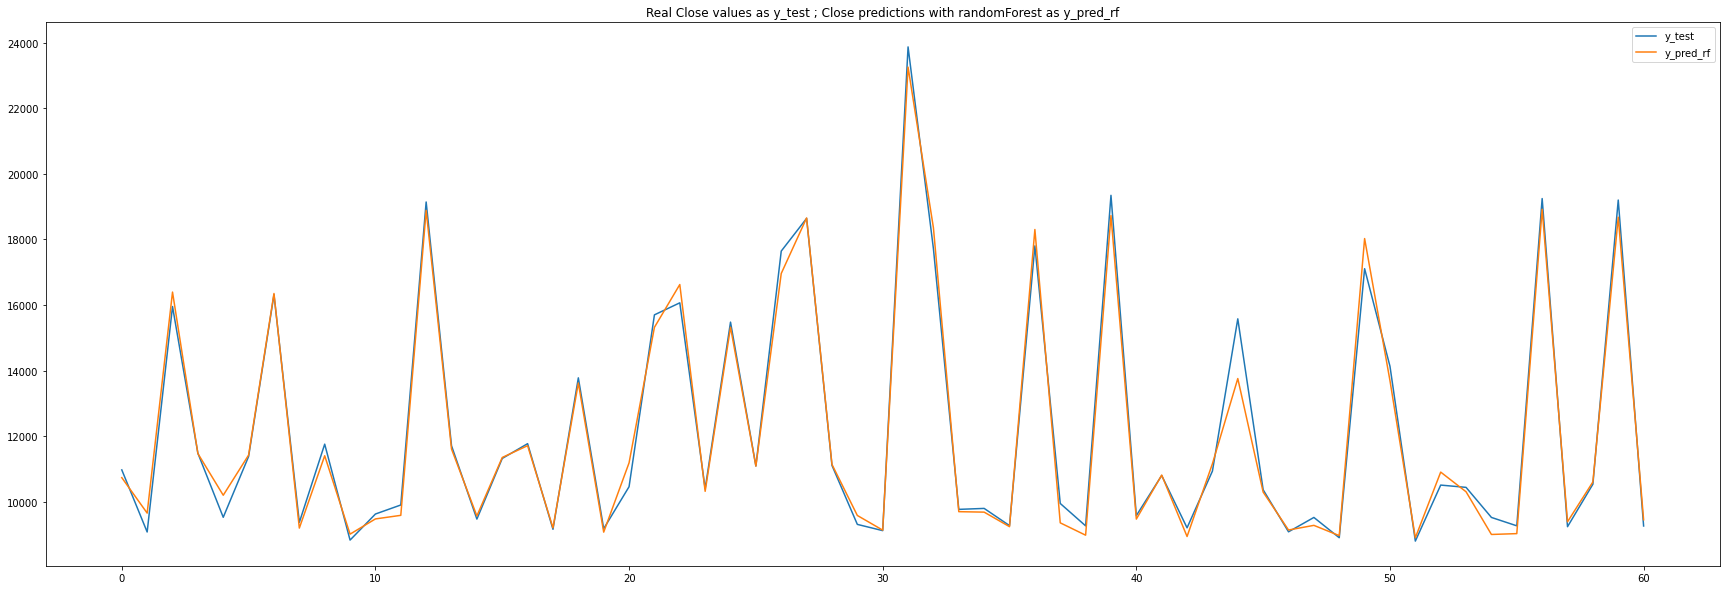

In [79]:
list_of_tuples = list(zip(y_test, y_pred_rf))
rf_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test', 'y_pred_rf'])
rf_res_df.plot(title ="Real Close values as y_test ; Close predictions with randomForest as y_pred_rf")

## KNN and RF without Google Trends data

In [80]:
y_wt = final_df["Close_shifted"]
X_wt = final_df.drop(["Close_shifted", "BTC"], axis = 1)
X_train_wt, X_test_wt, y_train_wt, y_test_wt = train_test_split(X_wt, y_wt, test_size = 0.25, random_state = 123)

In the interval 20239.1572265625 , performance metrics are as follows
RMSE:  4023.92349826773
MSE:  16191960.319911204
MAE:  2991.3420338114756


<AxesSubplot:title={'center':'Real Close values as y_test_wt ; Close predictions with knn as y_pred_knn_wt'}>

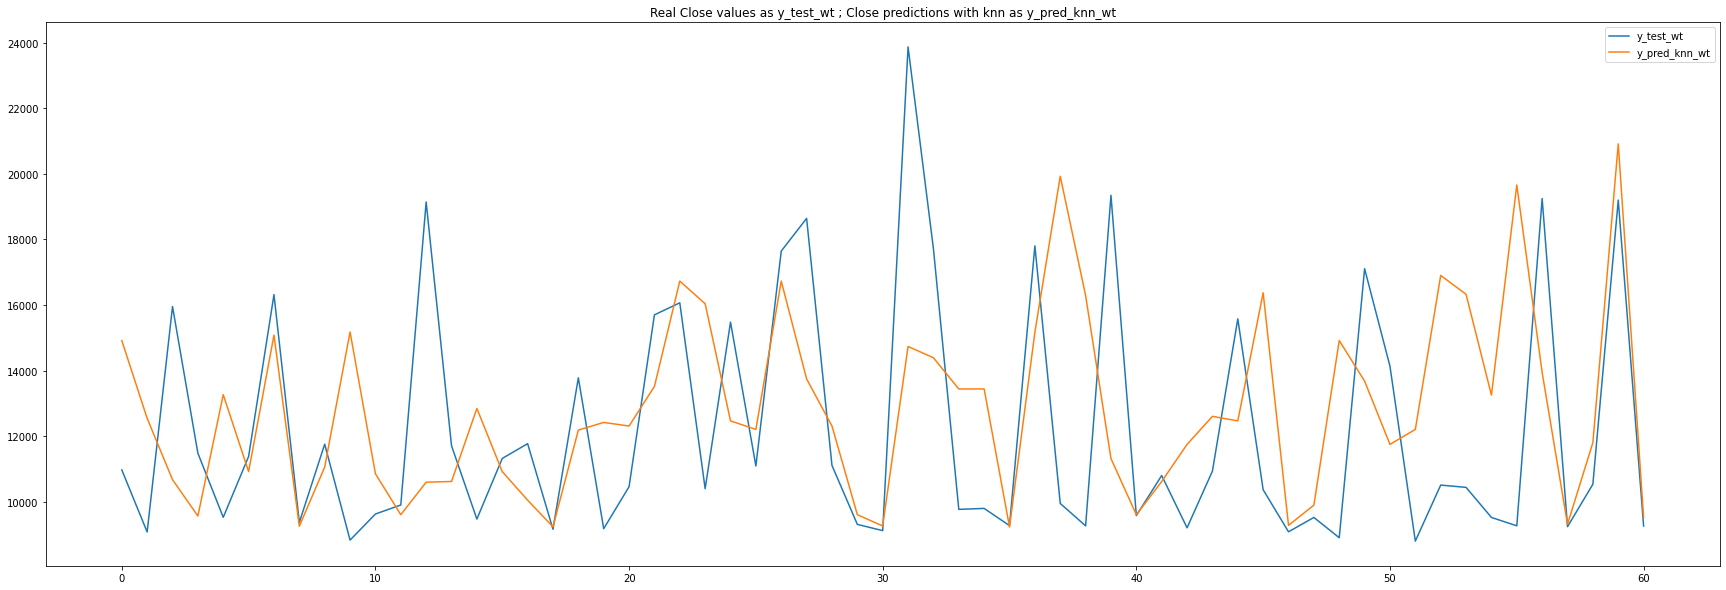

In [81]:
knn_model_wt = KNeighborsRegressor()
knn_model_wt.fit(X_train_wt, y_train_wt)

knn_model_wt.n_neighbors

y_pred_knn_wt = knn_model_wt.predict(X_test_wt)
y_pred_knn_wt[0:5]

scala = final_df["Close"].max() - final_df["Close"].min()
print("In the interval", scala, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test_wt, y_pred_knn_wt)))
print("MSE: ", mean_squared_error(y_test_wt, y_pred_knn_wt))
print("MAE: ", mean_absolute_error(y_test_wt, y_pred_knn_wt))

list_of_tuples = list(zip(y_test_wt, y_pred_knn_wt))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test_wt', 'y_pred_knn_wt'])
knn_res_df.plot(title ="Real Close values as y_test_wt ; Close predictions with knn as y_pred_knn_wt")

In the interval 20239.1572265625 , performance metrics are as follows
RMSE:  428.8537699865386
MSE:  183915.556031667
MAE:  289.83957543545097


<AxesSubplot:title={'center':'Real Close values as y_test_wt ; Close predictions with randomForest as y_pred_rf_wt'}>

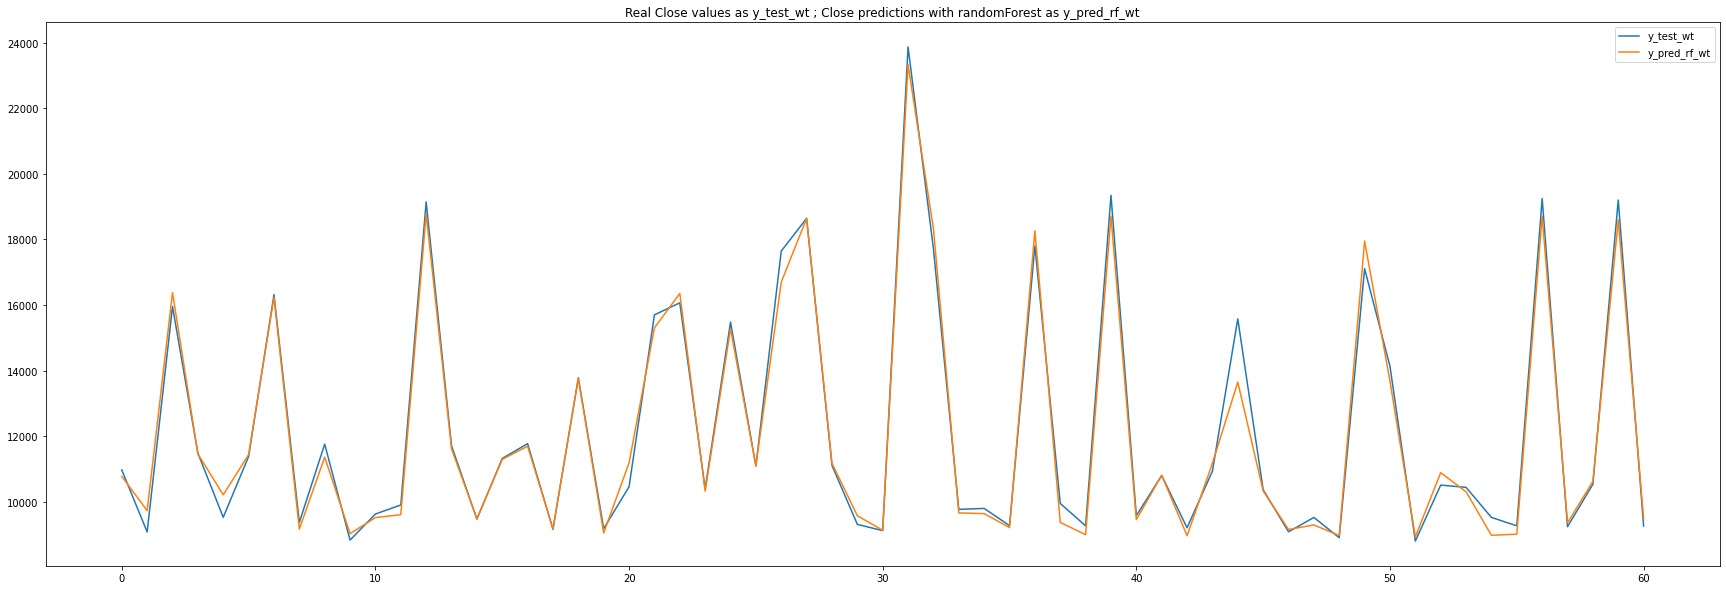

In [82]:
rf_model_wt =  RandomForestRegressor(random_state = 123)
rf_model_wt.fit(X_train_wt, y_train_wt)

y_pred_rf_wt = rf_model_wt.predict(X_test_wt)
y_pred_rf_wt[0:5]

scala = final_df["Close"].max() - final_df["Close"].min()
print("In the interval", scala, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test_wt, y_pred_rf_wt)))
print("MSE: ", mean_squared_error(y_test_wt, y_pred_rf_wt))
print("MAE: ", mean_absolute_error(y_test_wt, y_pred_rf_wt))

list_of_tuples = list(zip(y_test_wt, y_pred_rf_wt))
rf_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test_wt', 'y_pred_rf_wt'])
rf_res_df.plot(title ="Real Close values as y_test_wt ; Close predictions with randomForest as y_pred_rf_wt")

# MODEL SELECTION

In [83]:
knn_model_rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))
knn_model_mae = mean_absolute_error(y_test, y_pred_knn)

knn_model_scaled_rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_knn_scaled))
knn_model_scaled_mae = mean_absolute_error(y_test_scaled, y_pred_knn_scaled)

rf_model_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_model_mae = mean_absolute_error(y_test, y_pred_rf)

rf_model_wt_rmse = np.sqrt(mean_squared_error(y_test_wt, y_pred_rf_wt))
rf_model_wt_mae = mean_absolute_error(y_test_wt, y_pred_rf_wt)

knn_model_wt_rmse = np.sqrt(mean_squared_error(y_test_wt, y_pred_knn_wt))
knn_model_wt_mae = mean_absolute_error(y_test_wt, y_pred_knn_wt)

In [84]:
cmp_dic = {"knn_model": [knn_model_rmse, knn_model_mae],
            "knn_model_scaled": [knn_model_scaled_rmse, knn_model_scaled_mae],
            "rf_model": [rf_model_rmse, rf_model_mae],
            "rf_model_wt": [rf_model_wt_rmse, rf_model_wt_mae],
            "knn_model_wt": [knn_model_wt_rmse, knn_model_wt_mae]}  

cmp_df = pd.DataFrame(cmp_dic, index = ["rmse", "mae"])
cmp_df

,knn_model,knn_model_scaled,rf_model,rf_model_wt,knn_model_wt
rmse,4023.923498,0.022196,412.878134,428.853770,4023.923498
mae,2991.342034,0.014915,283.128235,289.839575,2991.342034


# MODEL OPTIMIZATION

In [85]:
rf_model.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'random_state',
 'ccp_alpha')

In [86]:
rf_params = {"max_depth": list(range(1, 10)),
                "max_features": [3, 5, 10, 15],
                "n_estimators": [100, 200, 500, 1000, 2000]}

In [87]:
rf_model = RandomForestRegressor(random_state = 123)
rf_cv_model = GridSearchCV(rf_model, rf_params, cv =  10, n_jobs = -1)

In [88]:
# rf_cv_model.fit(X_train, y_train)

In [89]:
# rf_cv_model.best_params_

In [90]:
rf_tuned = RandomForestRegressor(max_depth = 4, max_features = 3, n_estimators = 200)

In [91]:
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, max_features=3, n_estimators=200)

In [92]:
y_pred_rf_tuned = rf_tuned.predict(X_test)

# MODEL EVALUATION

In [93]:
scala = merged_df["Close"].max() - merged_df["Close"].min()
print("In the interval", scala, " performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned)))
print("MSE: ", mean_squared_error(y_test, y_pred_rf_tuned))
print("MAE: ", mean_absolute_error(y_test, y_pred_rf_tuned))

In the interval 20399.9248046875  performance metrics are as follows
RMSE:  442.9642095852851
MSE:  196217.29097351638
MAE:  302.7193981608865


Text(0.5, 0, 'Importance of variables when predicting BTC close values 1 period after from now')

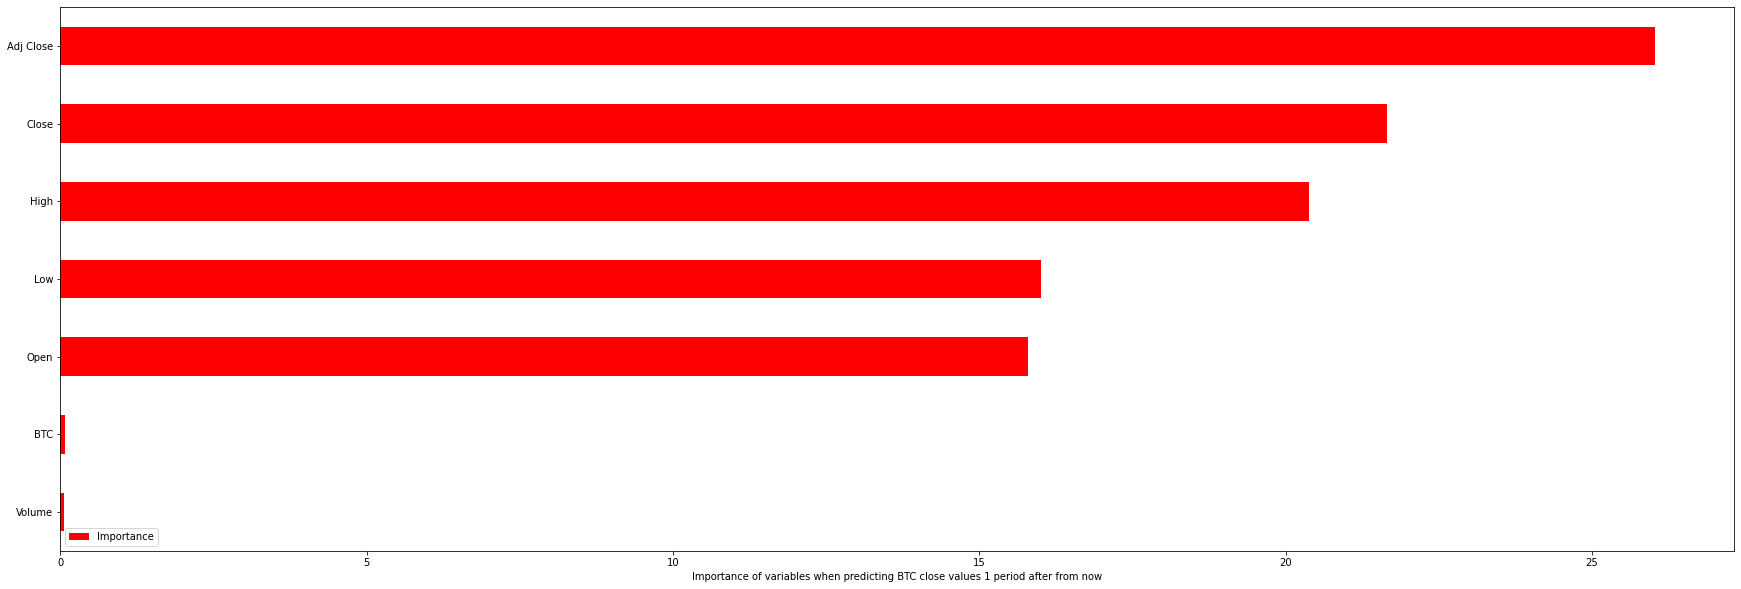

In [94]:
# Variable importance levels (percentage)
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_ * 100},
                            index = X_train.columns)
Importance.sort_values(by = "Importance", axis = 0, ascending = True).plot(kind = "barh",
color = "r")

plt.xlabel("Importance of variables when predicting BTC close values 1 period after from now")